## Summary: Two different techniques for solving a maze. One technique involves randomly meandering through the maze. The other trims away the unfruitul paths prior to walking through the maze. There're path optimization algorithms out there, so this is simply a project for fun.

## The input can be a maze image file with start at the top row and exit at the bottom row. Dark (ideally black) pixels for walls and light (ideally white) pixels for paths. Scroll down to examples below for visual references.

In [1]:
from PIL import Image
import cv2
import numpy as np
from scipy.misc import imread, imsave, imresize
import timeit
import imageio
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.animation as animation
from IPython.display import HTML
from skimage.transform import rescale, downscale_local_mean
from skimage.transform import resize as ski_resize
from skimage.io import imsave as ski_imsave
%matplotlib inline

print('modules imported.')

modules imported.


In [8]:
class maze (object):
    def __init__ (self, filename):
        self.ori_filepath = '/Users/zhonggao/Documents/Jupyter/test images/'
        self.filename = filename
        self.converted_filename = self.filename[0:-4] + '_bw' + self.filename[-4:]
        
    # Convert input image file to numpy array of 0's & 1's. 0's indicate maze walls. 1's indicate walkable paths.
    def convert (self):
        check_img_color = imageio.imread(self.ori_filepath + str(self.filename))
        
        # Convert image from RGB to grayscale if applicable.
        if len(check_img_color.shape) > 2:
            img_init = Image.open(self.ori_filepath + self.filename)
            img_convert = img_init.convert('1')
            img_convert.save(self.ori_filepath + self.converted_filename)
            img = Image.open(self.ori_filepath + self.converted_filename)
        self.img = np.where(np.amax(cv2.imread(self.ori_filepath + self.filename), axis = 2) > 1, 1, 0)
        self.left_margin, self.top_margin = 0, 0
        
        # check if the boundary needs to be cropped
        if self.img[0][0] == 1:
            search_corners = np.array(np.where(self.img == 0))
            nw_corner = search_corners[:, 0]
            se_corner = search_corners[:, -1]
            self.img = self.img[nw_corner[0]:se_corner[0] + 1, nw_corner[1]:se_corner[1] + 1]

        cell_widths = []
        path_color = 1
        for pixel_row in self.img:
            cell_width = 0
            for pixel in pixel_row:
                if pixel == path_color:
                    cell_width += 1
                else:
                    if cell_width > 0:
                        cell_widths.append(cell_width)
                    cell_width = 0

        cell_heights = []
        for pixel_row in np.transpose(self.img):
            cell_height = 0
            for pixel in pixel_row:
                if pixel == path_color:
                    cell_height += 1
                else:
                    if cell_height > 0:
                        cell_heights.append(cell_height)
                    cell_height = 0

        scale_down_factor = min(min(cell_heights), min(cell_widths))
        
        # Scale the maze down so the maze walls & paths are of 1 pixel widths.
        # This is done to facilitate later path searching as well as aligning maze background picture with the solved path overlay.
        if scale_down_factor > 1:
            orig_width, orig_height = self.img.shape
            self.img = ski_resize(self.img, (int(orig_width / scale_down_factor), int(orig_height / scale_down_factor)), anti_aliasing=False) * 255
            self.img = np.where(self.img > ((np.max(self.img)) + np.min(self.img))/2, 1, 0)
            ski_imsave(self.ori_filepath + self.converted_filename, self.img * 255)

    # Display the maze in numpy format (in binary)
    def show_maze_binary(self):
        self.convert()
        print(self.img)

    # Renders the maze image
    def show_maze (self, width = 6, height = 6):
        self.width = width
        self.height = height
        plt.figure(figsize=(self.width, self.height))
        self.maze_image = Image.open(self.ori_filepath + self.filename)
        imshow(np.asanyarray(self.maze_image), interpolation='nearest')
        

    # Search the previously generated numpy format of maze for all possible nodes. A node is defined as cul de sac's, junctions or bends in the maze path.
    # Nodes will be arranged in a numpy format by rows, to be used in later path solving.
    def find_nodes (self):
        self.all_nodes = []
        for row_num, row in enumerate(self.img):
            i_nodes = []
            if row_num == 0:
                self.all_nodes.append([[row_num, np.argmax(row), ['S']]])
            elif row_num == len(self.img)-1:
                self.all_nodes.append([[row_num, np.argmax(row), ['N']]])
            else:
                checked_cols = []
                col_counter = 0
                for col, value in enumerate(row):
                    directions = []
                    if (value == 1) and ((self.img[row_num - 1][col] == 1) or (self.img[row_num + 1][col] == 1)) and ((row[col - 1] == 1) or (row[col + 1] == 1)):
                        if self.img[row_num - 1][col] == 1:
                            directions.append('N')
                        else:
                            pass
                        if row[col + 1] == 1:
                            directions.append('E')
                        else:
                            pass
                        if self.img[row_num + 1][col] == 1:
                            directions.append('S')
                        else:
                            pass
                        if row[col - 1] == 1:
                            directions.append('W')
                        else:
                            pass
                        i_m_node = [row_num, col, directions]
                        i_nodes.append(i_m_node)
                    elif (value == 1) and ((self.img[row_num - 1][col] == 1) ^ (self.img[row_num + 1][col] == 1) ^ (row[col - 1] == 1) ^ (row[col + 1] == 1) == 1):
                        if self.img[row_num - 1][col] == 1:
                            directions.append('N')
                        else:
                            pass
                        if row[col + 1] == 1:
                            directions.append('E')
                        else:
                            pass
                        if self.img[row_num + 1][col] == 1:
                            directions.append('S')
                        else:
                            pass
                        if row[col - 1] == 1:
                            directions.append('W')
                        else:
                            pass
                        i_m_node = [row_num, col, directions]
                        i_nodes.append(i_m_node)
                    checked_cols.append(value)
                self.all_nodes.append(i_nodes)

    # Finds the node index in numpy format of the maze, given the node's X & Y coordinates.
    def find_index (self, row, col_num):
        for index, cell in enumerate(row):
            if cell[1] == col_num:
                return index
    
    # Allow random walk within the maze. Stop when either the maze is solved, or specified maximum steps are exhausted.
    def meander (self, max_steps = None):
        self.positions = []
        position = self.all_nodes[0][0][0:2]
        for step in range(self.max_steps):
            node = self.all_nodes[position[0]][self.find_index(self.all_nodes[position[0]], position[1])]
            self.positions.append(position)
            num_direction = len(self.all_nodes[position[0]][self.find_index(self.all_nodes[position[0]], position[1])][2])
            direction = node[2][random.randint(0,num_direction-1)]
            if position == self.all_nodes[-1][0][0:2]:
                return 'Success', self.positions
            if step == self.max_steps - 1:
                return 'Failed', self.positions
            elif direction == 'S':
                for row_num, row in enumerate(self.all_nodes[position[0] + 1:]):
                    if str(self.find_index(row, position[1])).isdigit():
                        new_row_num = position[0] + row_num + 1
                        new_col_num = position[1]
                        position = [new_row_num, new_col_num]
                        break
            elif direction == 'N':
                for row_num, row in enumerate(self.all_nodes[0:position[0]][::-1]):
                    if str(self.find_index(row, position[1])).isdigit():
                        new_row_num = position[0] - row_num - 1
                        new_col_num = position[1]
                        position = [new_row_num, new_col_num]
                        break
            elif direction == 'W':
                new_row_num = position[0]
                new_col_num = self.all_nodes[position[0]][self.find_index(self.all_nodes[position[0]], position[1]) - 1][1]
                position = [new_row_num, new_col_num]
            elif direction == 'E':
                new_row_num = position[0]
                new_col_num = self.all_nodes[position[0]][self.find_index(self.all_nodes[position[0]], position[1]) + 1][1]
                position = [new_row_num, new_col_num]
            else:
                pass
    
    # Attempt solving the maze once, by means of randomly walking the maze within the specified maximum steps.
    def single_solve (self):
        try:
            self.meander(self.max_steps)
        except:
            self.convert()
            self.find_nodes()
        return self.meander()

    # Attempt multiple times at solving the maze by random walk technique.
    def pick_solve (self, attempts = None, max_steps = None):
        check_img_color = imageio.imread(self.ori_filepath + str(self.filename))
        self.maze_width = check_img_color.shape[0]
        if attempts == None:
            self.attempts = max(5, int(10000/(self.maze_width ** 2)))
        else:
            self.attempts = attempts
            
        self.path_logs = []
        
        for attempt in range(self.attempts):
            t = self.single_solve()
            if t[0] == 'Failed':
                pass
            elif t[0] == 'Success':
                self.path_logs.append(self.positions)
            

        try:
            self.chosen_path = min(self.path_logs, key=len)
            return self.chosen_path
        except ValueError:
            print('No path found given the parameters!')

    # Solve the maze within the specified number of steps using random walk technique, as well as rendering the final solution in HTML5 Video format.
    def solve (self,
               attempts = None,
               max_steps = None,
               vid_duration = None,
               save_count = 5000):
        check_img_color = cv2.imread(self.ori_filepath + self.filename[0:-4] + '_bw' + self.filename[-4:])
        self.maze_width_ = check_img_color.shape[0]
        if max_steps == None:
            self.max_steps = 25 * self.maze_width_
        else:
            self.max_steps = max_steps
        self.pick_solve(attempts = attempts, max_steps = self.max_steps)
        if vid_duration == None:
            self.vid_duration = int(self.maze_width_ / 5)
        else:
            self.vid_duration = vid_duration

        # optimize path by eliminating any unnecessary loops
        max_period = len(self.chosen_path) - self.maze_width
        
        for period in reversed(range(max_period)):
            for index, position in enumerate(self.chosen_path):
                if index == 0:
                    pass
                try:
                    end_index = index + period
                    if position == self.chosen_path[end_index]:
                        del self.chosen_path[index: end_index]
                except:
                    pass
                
        
        self.interval = int(self.vid_duration * 1000/len(self.chosen_path))
        self.save_count = save_count
        
        if self.save_count < len(self.chosen_path):
            print('Too many steps to animate. Recommend increasing the save_count variable.')
            return 0
        try:
            # Generate animation of the solution for the maze
            def draw_path(i):
                x = self.chosen_path[i][1]
                y = self.chosen_path[i][0]
                xs = [x[1] for x in self.chosen_path[0:i+1]]
                ys = [y[0] for y in self.chosen_path[0:i+1]]
                ani_path[0].set_data(xs, ys)
                ani_arrow[0].set_data(x, y)
                try:
                    if self.chosen_path[i + 1][0] > self.chosen_path[i][0]:
                        ani_arrow[0].set_marker(11)
                    elif self.chosen_path[i + 1][0] < self.chosen_path[i][0]:
                        ani_arrow[0].set_marker(10)
                    elif self.chosen_path[i + 1][1] > self.chosen_path[i][1]:
                        ani_arrow[0].set_marker(9)
                    elif self.chosen_path[i + 1][1] < self.chosen_path[i][1]:
                        ani_arrow[0].set_marker(8)
                except:
                    ani_arrow[0].set_marker(11)
            
                return patch
            
            frames = len(self.chosen_path)
            img = plt.imread(self.ori_filepath + self.converted_filename)
            fig, ax = plt.subplots()
            ax.imshow(img, cmap="gray")
            y, x = self.chosen_path[0]
            ani_path = plt.plot([],[], lw = 2, color = 'orange')
            ani_arrow = plt.plot(x, y, color = 'purple', marker = 7, markersize = 10)
            
            patch = ani_path + ani_arrow
            
            self.ani = animation.FuncAnimation(fig,
                                               draw_path,
                                               frames=frames,
                                               interval = self.interval,
                                               repeat = False,
                                               save_count = frames)

            print('Total attempts: ', str(self.attempts))
            print('Min. Total steps: ', str(frames))
            return HTML(self.ani.to_html5_video())
        except AttributeError:
            print('No visualization possible.')


    def trim_branches (self, all_nodes = None):
        
        # A helper function to compute opposite direction.
        # Used to eliminate previously attempted unfruitful paths.
        def calc_oppo_dir (last_direction):
            if last_direction == 'N':
                return 'S'
            elif last_direction == 'S':
                return 'N'
            elif last_direction == 'W':
                return 'E'
            elif last_direction == 'E':
                return 'W'

        def find_node (all_nodes, x, y):
            match_node = []
            for row_num, row in enumerate(all_nodes):
                for col_num, node in enumerate(row):
                    if node[1] == x and node[0] == y:
                        match_node = node
            return match_node
        
        # Find the last node during maze navigation
        def find_last_node (all_nodes, c_node):
            try:
                flattened_nodes = [node for row in all_nodes for node in row]
            except:
                flattened_nodes = all_nodes
            flattened_xs = [i[1] for i in flattened_nodes if i != []]
            flattened_ys = [i[0] for i in flattened_nodes if i != []]
            max_x = max(flattened_xs)
            max_y = max(flattened_ys)

            if len(c_node[2]) == 1:
                y, x, [direction] = c_node
                if direction == 'N':
                    for i in reversed(range(y)):
                        res = find_node(all_nodes=all_nodes, x=x, y=i)
                        if res != []:
                            return res
                elif direction == 'S':
                    for i in range(y + 1, max_y):
                        res = find_node(all_nodes=all_nodes, x=x, y=i)
                        if res != []:
                            return res
                elif direction == 'E':
                    for i in range(x + 1, max_x + 1):
                        res = find_node(all_nodes=all_nodes, x=i, y=y)
                        if res != []:
                            return res
                elif direction == 'W':
                    for i in reversed(range(1, x)):
                        res = find_node(all_nodes=all_nodes, x=i, y=y)
                        if res != []:
                            return res
                else:
                    print('Unknown direction: ', direction)
            else:
                print('Not end point: (len(c_node) != 1), check find_last_node function.')
        
        
        if all_nodes is None:
            all_nodes = self.all_nodes

        # Flatten maze nodes to ease computation
        flattened_nodes = [node for row in all_nodes for node in row]
        max_y = flattened_nodes[-1][0]
        for node in flattened_nodes:
            if node[0] != 0 and node[0] != max_y: 
                if len(node[2]) == 1 and node[0] != 0:
                    last_node = find_last_node(all_nodes, node)
                    c_n_dir = node[2][0]
                    l_dir = calc_oppo_dir(c_n_dir)
                    last_node[2].remove(l_dir)
                    flattened_nodes.remove(node)
                    reformed_all_nodes = self.reform_nodes(flattened_nodes)
                    return self.trim_branches(all_nodes = reformed_all_nodes)
            elif node[0] == max_y:
                return flattened_nodes

    # Restructure the flattened maze numpy back to a 2D array, arranged by rows.
    def reform_nodes (self, flattened_nodes):
        self.reformed_nodes = [[flattened_nodes[0]]]
        max_y = flattened_nodes[-1][0]
        for i in range(1, max_y + 1):
            counter = 0
            for node in flattened_nodes:
                if node[0] == i:
                    self.reformed_nodes[i].append(node)
                elif node[0] != i and counter == 0:
                    self.reformed_nodes.append([])
                    counter += 1
        return self.reformed_nodes

    # Initially randomly walk through the maze, but memorize the steps taken. Won't re-attempt unfruitful steps.
    def meander1 (self, max_steps = None):
            if max_steps == None:
                self.max_steps = 1000

            def calc_oppo_dir (last_direction):
                if last_direction == 'N':
                    return 'S'
                elif last_direction == 'S':
                    return 'N'
                elif last_direction == 'W':
                    return 'E'
                elif last_direction == 'E':
                    return 'W'
                
            def find_node (all_nodes, x, y):
                match_node = []
                for row_num, row in enumerate(all_nodes):
                    for col_num, node in enumerate(row):
                        if node[1] == x and node[0] == y:
                            match_node = node
                return match_node

            node = self.all_nodes[0][0]
            y, x = self.all_nodes[0][0][0:2]
            self.positions = [[y, x]]
            flattened_nodes_ = [node for row in self.all_nodes for node in row]
            xs_ = [x[1] for x in flattened_nodes_]
            ys_ = [x[0] for x in flattened_nodes_]
            max_x = max(xs_)
            max_y = max(ys_)
            for step in range(self.max_steps):
                if node[0] == max_y:
                    break
                
                direction_list = node[2]
                direction = random.choice(direction_list)
                oppo_direction = calc_oppo_dir(direction)
                if direction == 'N':
                    for i in reversed(range(y)):
                        node = find_node(all_nodes=self.all_nodes, x=x, y=i)
                        if node != []:
                            x = node[1]
                            y = node[0]
                            self.positions.append([y, x])
                            try:
                                node[2].remove(oppo_direction)
                            except:
                                pass
                            break
                elif direction == 'S':
                    for i in range(y + 1, max_y + 1):
                        node = find_node(all_nodes=self.all_nodes, x=x, y=i)
                        if node != []:
                            x = node[1]
                            y = node[0]
                            self.positions.append([y, x])
                            try:
                                node[2].remove(oppo_direction)
                            except:
                                pass
                            break
                elif direction == 'E':
                    for i in range(x + 1, max_x + 1):
                        node = find_node(all_nodes=self.all_nodes, x=i, y=y)
                        if node != []:
                            x = node[1]
                            y = node[0]
                            self.positions.append([y, x])
                            try:
                                node[2].remove(oppo_direction)
                            except:
                                pass
                            break
                elif direction == 'W':
                    for i in reversed(range(1, x)):
                        node = find_node(all_nodes=self.all_nodes, x=i, y=y)
                        if node != []:
                            x = node[1]
                            y = node[0]
                            self.positions.append([y, x])
                            try:
                                node[2].remove(oppo_direction)
                            except:
                                pass
                            break
    
    # Solve the maze within the specified number of steps by avoiding previously attempted unfuitful steps, as well as rendering the final solution in HTML5 Video format.
    def trim_solve (self,
                   max_steps = None,
                   vid_duration = None,
                   save_count = 5000):
            check_img_color = cv2.imread(self.ori_filepath + self.filename[0:-4] + '_bw' + self.filename[-4:])
            self.maze_width_ = check_img_color.shape[0]
            if max_steps == None:
                self.max_steps = 25 * self.maze_width_
            else:
                self.max_steps = max_steps

            self.convert()
            self.find_nodes()
            trimmed_flattened_nodes = self.trim_branches()
            self.all_nodes = [x[0:len(x)] for x in self.reform_nodes(trimmed_flattened_nodes) if x != []]
            self.meander1()

            # Optimize path by eliminating any unnecessary loops
            check_img_color = imageio.imread(self.ori_filepath + str(self.filename))
            self.maze_width = check_img_color.shape[0]
            max_period = len(self.positions) - self.maze_width

            for period in reversed(range(max_period)):
                for index, position in enumerate(self.positions):
                    if index == 0:
                        pass
                    try:
                        end_index = index + period
                        if position == self.positions[end_index]:
                            del self.positions[index: end_index]
                    except:
                        pass

            if vid_duration == None:
                self.vid_duration = int(self.maze_width_ / 5)
            else:
                self.vid_duration = vid_duration


            self.interval = int(self.vid_duration * 1000/len(self.positions))
            self.save_count = save_count

            if self.save_count < len(self.positions):
                print('Too many steps to animate. Recommend increasing the save_count variable.')
                return 0
            
            # Generate animation of maze solution in HTML5 Video format.
            def draw_path(i):
                x = self.positions[i][1]
                y = self.positions[i][0]
                xs = [x[1] for x in self.positions[0:i+1]]
                ys = [y[0] for y in self.positions[0:i+1]]
                ani_path[0].set_data(xs, ys)
                ani_arrow[0].set_data(x, y)
                try:
                    if self.positions[i + 1][0] > self.positions[i][0]:
                        ani_arrow[0].set_marker(11)
                    elif self.positions[i + 1][0] < self.positions[i][0]:
                        ani_arrow[0].set_marker(10)
                    elif self.positions[i + 1][1] > self.positions[i][1]:
                        ani_arrow[0].set_marker(9)
                    elif self.positions[i + 1][1] < self.positions[i][1]:
                        ani_arrow[0].set_marker(8)
                except:
                    ani_arrow[0].set_marker(11)

                return patch

            frames = len(self.positions)
            img = plt.imread(self.ori_filepath + self.converted_filename)
            fig, ax = plt.subplots()
            ax.imshow(img, cmap="gray")
            y, x = self.positions[0]

            ani_path = plt.plot([],[], lw = 2, color = 'orange')
            ani_arrow = plt.plot(x, y, color = 'purple', marker = 7, markersize = 10)

            patch = ani_path + ani_arrow

            self.ani = animation.FuncAnimation(fig,
                                               draw_path,
                                               frames=frames,
                                               interval = self.interval,
                                               repeat = False,
                                               save_count = frames)
            print('Total steps: ', len(self.positions))
            return HTML(self.ani.to_html5_video())
        


Total steps:  12


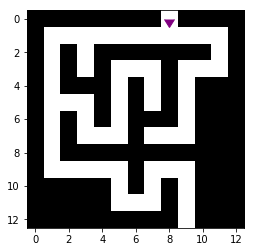

In [3]:
maze_1 = maze('maze_1.png')
maze_1.trim_solve()

Total attempts:  10
Min. Total steps:  12


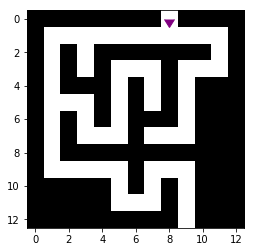

In [10]:
maze_1.solve()

Total steps:  16


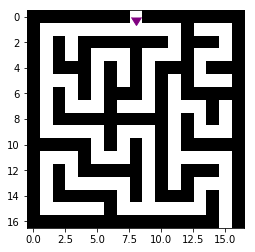

In [4]:
maze_2 = maze('maze_2.png')
maze_2.trim_solve()

Total attempts:  10
Min. Total steps:  16


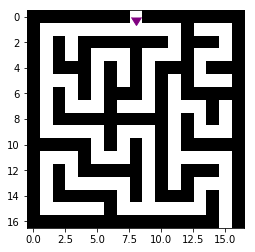

In [11]:
maze_2.solve()

Total steps:  38


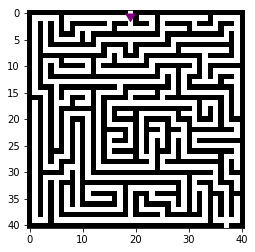

In [5]:
maze_3 = maze('maze_3.png')
maze_3.trim_solve()

Total attempts:  10
Min. Total steps:  38


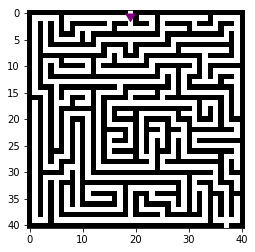

In [12]:
maze_3.solve()

Total steps:  73


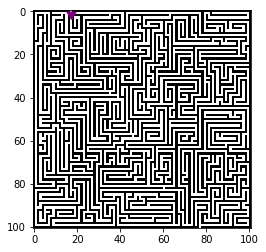

In [8]:
maze_4 = maze('maze_4.png')
maze_4.trim_solve()

Total attempts:  10
Min. Total steps:  64


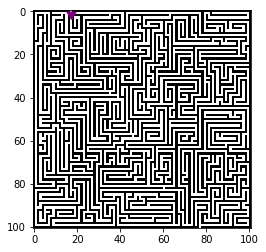

In [21]:
maze_4.solve(max_steps=9000, attempts=10)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: /Users/zhonggao/Documents/Jupyter/test images/maze_5_bw.png is a low contrast image
  warn('%s is a low contrast image' % fname)


Total steps:  64


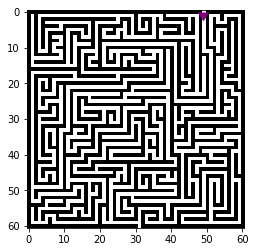

In [9]:
maze_5 = maze('maze_5.png')
maze_5.trim_solve()

Total attempts:  10
Min. Total steps:  64


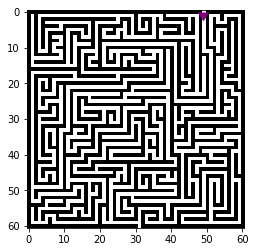

In [17]:
maze_5.solve(max_steps=5000)